# data preprocessing

In [1]:
import pandas as pd
import numpy as np
products = pd.read_csv('amazon_baby_subset.csv')
import json
with open('important_words.json', 'r') as f:
    important_words = json.loads(f.read())
print(important_words, len(important_words))

['baby', 'one', 'great', 'love', 'use', 'would', 'like', 'easy', 'little', 'seat', 'old', 'well', 'get', 'also', 'really', 'son', 'time', 'bought', 'product', 'good', 'daughter', 'much', 'loves', 'stroller', 'put', 'months', 'car', 'still', 'back', 'used', 'recommend', 'first', 'even', 'perfect', 'nice', 'bag', 'two', 'using', 'got', 'fit', 'around', 'diaper', 'enough', 'month', 'price', 'go', 'could', 'soft', 'since', 'buy', 'room', 'works', 'made', 'child', 'keep', 'size', 'small', 'need', 'year', 'big', 'make', 'take', 'easily', 'think', 'crib', 'clean', 'way', 'quality', 'thing', 'better', 'without', 'set', 'new', 'every', 'cute', 'best', 'bottles', 'work', 'purchased', 'right', 'lot', 'side', 'happy', 'comfortable', 'toy', 'able', 'kids', 'bit', 'night', 'long', 'fits', 'see', 'us', 'another', 'play', 'day', 'money', 'monitor', 'tried', 'thought', 'never', 'item', 'hard', 'plastic', 'however', 'disappointed', 'reviews', 'something', 'going', 'pump', 'bottle', 'cup', 'waste', 'retu

In [2]:
def remove_punctuation(text):
    import string
    text = text.str.replace('[^\w\s]', '')
    return text

In [3]:
products = products.fillna({'review':''})
products['review_clean'] = remove_punctuation(products['review'])
products.columns

Index(['name', 'review', 'rating', 'sentiment', 'review_clean'], dtype='object')

In [4]:
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : float(s.split().count(word)))

# train validation split

In [5]:
with open('module-4-assignment-train-idx.json', 'r') as f:
    train_idx = json.loads(f.read())
with open('module-4-assignment-validation-idx.json', 'r') as f:
    valid_idx = json.loads(f.read())

train_data = products.iloc[train_idx]
valid_data = products.iloc[valid_idx]
print(len(train_data) , len(valid_data), len(products))

42361 10711 53072


In [6]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    feature_matrix = dataframe[features].values
    label_array = dataframe[label].values
    return feature_matrix, label_array

In [ ]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(valid_data, important_words, 'sentiment') 
print(feature_matrix_train.shape, sentiment_train.shape, feature_matrix_valid.shape, sentiment_valid.shape)

# l2 regularized logistic regression blocks

In [14]:
def predict_probability(feature_matrix, coefficients):
    score = np.dot(feature_matrix,coefficients)
    predictions = 1/(1+np.exp(-score))
    return predictions

In [15]:
def feature_derivative_with_l2(errors, feature, coefficient, l2_penalty, feature_is_constant): 
    derivative = np.dot(errors, feature)
    if not feature_is_constant: 
        derivative -= 2*l2_penalty*coefficient
    return derivative

In [19]:
def compute_log_likelihood_with_l2(feature_matrix, labels, coefficients):
    indicator = (labels==+1)
    scores = np.dot(feature_matrix, coefficients)
    lp1 = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores)))
    
    pbar = 1/(1+np.exp(-scores))
    lp2 = np.sum(indicator *np.log(pbar) +(1-indicator)*np.log(1-pbar) )
    return lp1

In [20]:
def logistic_regression_with_l2(feature_matrix, labels, initial_coefficients, l2_penalty, step_size, max_iter):
    coef = np.array(initial_coefficients, dtype=float)
    d = coef.shape[0]
    indicator = (labels == 1).astype(float)
    for itr in range(max_iter):
        pred = predict_probability(feature_matrix, coef)
        errors = indicator - pred
        for j in range(1,d):
            is_constant = True if j == 0 else False
            coef[j] += step_size * feature_derivative_with_l2(errors, feature_matrix[:,j], l2_penalty, coef[j], is_constant)
    # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_l2(feature_matrix, labels, coef)
            print ('iteration %*d: log likelihood of observed labels = %.8f' %(int(np.ceil(np.log10(max_iter))), itr, lp))
    return coef

# select l2-penalty in l2-penalized logistic regression

In [ ]:
lam = [0., 4., 10., 1.0e2, 1.0e3, 1.0e5]
step_size = 5e-6
max_iter = 501
coef_sets = []
for l2_penalty in lam:
    coef = logistic_regression_with_l2(feature_matrix_train, sentiment_train, [0 for _ in range(194)], l2_penalty, step_size, max_iter)
    coef_sets.append(coef)

In [38]:
word_coefficients_tuples = [(tup[0],list(tup[1:])) for tup in zip(important_words, coef_sets[0][1:], coef_sets[1][1:], coef_sets[2][1:], 
                                               coef_sets[3][1:], coef_sets[4][1:], coef_sets[5][1:])]

In [43]:
most_positive = sorted(word_coefficients_tuples, key=lambda elem:elem[1][0], reverse=True)
most_negative = sorted(word_coefficients_tuples, key=lambda elem:elem[1][0])
positive_words = []
for tuples in most_positive[0:5]:
    positive_words.append(tuples[0])
negative_words = []
for tuples in most_negative[0:5]:
    negative_words.append(tuples[0])
print(positive_words)
print(negative_words)

['love', 'loves', 'easy', 'perfect', 'great']
['disappointed', 'money', 'return', 'waste', 'returned']


In [48]:
table = {}
for item in word_coefficients_tuples:
    table[item[0]] = item[1]

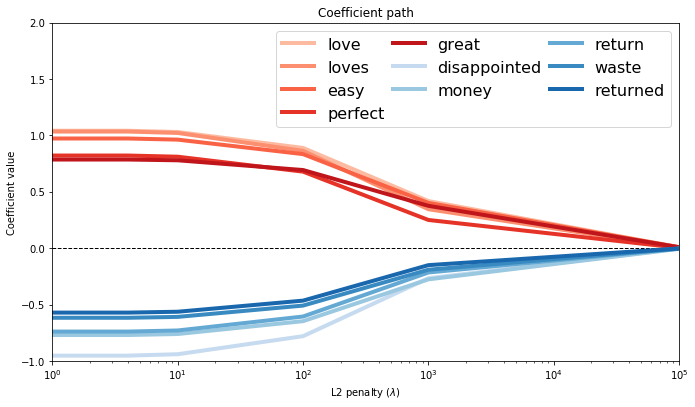

In [52]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = []
    table_negative_words = []
    for word in positive_words:
#         print(table[word])
        table_positive_words.append(table[word])
    for word in negative_words:
        table_negative_words.append(table[word])
    
    for i in range(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i],
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i in range(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i],
                 '-', label=negative_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()


make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

# compute accuracy

In [81]:
accuracy = []
for l2_penalty, coef in zip(lam, coef_sets):
    score = np.dot(feature_matrix_train,coef)
    num = np.sum( (score > 0) == (sentiment_train == 1) )
    acc = num / score.shape[0]
    accuracy.append(acc)
    print(l2_penalty, acc)

0.0 0.7856282901725644
4.0 0.7855338636953801
10.0 0.785463043837492
100.0 0.7846840254007224
1000.0 0.7741790798139798
100000.0 0.7446944123132127


In [82]:
accuracy = []
for l2_penalty, coef in zip(lam, coef_sets):
    score = np.dot(feature_matrix_valid,coef)
    num = np.sum( (score > 0) == (sentiment_valid == 1) )
    acc = num / score.shape[0]
    accuracy.append(acc)
    print(l2_penalty, acc)

0.0 0.7827467089907572
4.0 0.7826533470264214
10.0 0.7825599850620857
100.0 0.7812529175613855
1000.0 0.7711698254131267
100000.0 0.7441882177201008
